# Audio Data Augmentation

In [1]:
#Export 
from exp.nb_AudioCommon import *

In [2]:
#Export
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
from fastai.text import * 
from fastai.vision import *
import torch
import librosa
import torchaudio
from torchaudio import transforms

## IMPORTANT: audio transformations I/O is AudioData type

All the audio transformations operates on AudioData type

In [3]:
#Export
def show_AudioData(ad:AudioData):
    print(f'sr:{example.sr}   sig.shape:{example.sig.shape}')
    display(Audio(data=ad.sig, rate=ad.sr))  

## Sample Data: Timit

In [4]:
path = getFastAiWorkingDirectory('timit')

Working directory: /home/ubuntu/.fastai/data/timit


In [5]:
example = AudioData.load(str(path/'TRAIN/DR1/MDPK0/SA1.WAV'))
show_AudioData(example)

sr:16000   sig.shape:torch.Size([46080])


**IMPORTANT: We want the sample to be a unidimensional tensor**
<br />
We're using **(sig,sr)** for all our tests.

## Setup

In [6]:
#Export
def show_in_out(s:AudioData, r:AudioData):
    """Helper to plot input and output signal in different colors"""
    if s is not None: plt.plot(s.sig, 'g')
    if r is not None: plt.plot(r.sig, 'r')

In [7]:
#Export
def tfm_tester(testSignal:AudioData, tfm, **kwargs):
    #TODO: track performance of execution
    tfms = listify(tfm)
    ret = testSignal # default pass
    for t in tfms:
        ret = t(ret, **kwargs)
    show_AudioData(testSignal)
    show_AudioData(ret)
    show_in_out(testSignal, ret)

# Augmentation Functions

## White Noise

In [8]:
#Export
def tfm_add_white_noise(ad:AudioData, noise_scl=0.005, **kwargs)->AudioData:
    noise = torch.randn(ad.sig.shape[0]) * noise_scl
    return AudioData(ad.sig + noise, ad.sr)

In [9]:
%timeit -n100 tfm_add_white_noise(example)

538 µs ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit -n100 tfm_modulate_volume(example)

NameError: name 'tfm_modulate_volume' is not defined

In [ ]:
%timeit -n100 tfm_random_cutout(example)

In [ ]:
%timeit -n100 tfm_pad_with_silence(example)

In [11]:
%timeit -n100 tfm_pitch_warp(example)

NameError: name 'tfm_pitch_warp' is not defined

In [12]:
%timeit -n100 tfm_down_and_up(example)

NameError: name 'tfm_down_and_up' is not defined

sr:16000   sig.shape:torch.Size([46080])


sr:16000   sig.shape:torch.Size([46080])


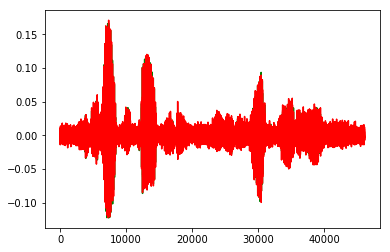

In [14]:
tfm_tester(example, tfm_add_white_noise)

## Volume Change

In [15]:
#Export
def tfm_modulate_volume(ad:AudioData, lower_gain=.1, upper_gain=1.2, **kwargs)->AudioData:
    modulation = random.uniform(lower_gain, upper_gain)
    return AudioData(ad.sig * modulation, ad.sr)

sr:16000   sig.shape:torch.Size([46080])


sr:16000   sig.shape:torch.Size([46080])


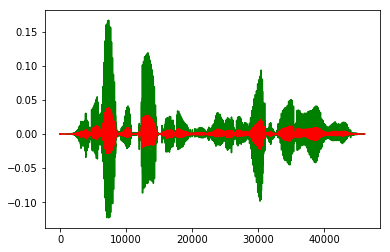

In [16]:
tfm_tester(example, tfm_modulate_volume)

## Random Cutout

In [17]:
#Export
def tfm_random_cutout(ad:AudioData, pct_to_cut=.15, **kwargs)->AudioData:
    """Randomly replaces `pct_to_cut` of signal with silence. Similar to grainy radio."""
    copy = ad.sig.clone()
    sig_len = copy.shape[0]
    sigs_to_cut = int(sig_len * pct_to_cut)
    for i in range(0, sigs_to_cut):
        cut_idx = random.randint(0, sig_len - 1)
        copy[cut_idx] = 0
    return AudioData(copy,ad.sr)

sr:16000   sig.shape:torch.Size([46080])


sr:16000   sig.shape:torch.Size([46080])


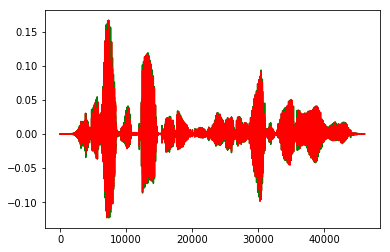

In [18]:
tfm_tester(example, partial(tfm_random_cutout,pct_to_cut=.95))

## Pad with Silence

In [19]:
#Export
def tfm_pad_with_silence(ad:AudioData, pct_to_pad=.15, min_to_pad=None, max_to_pad=None, **kwargs)->AudioData:
    """Adds silence to beginning or end of signal, simulating microphone cut at start of end of audio."""
    if max_to_pad is None: max_to_pad = int(ad.sig.shape[0] * 0.15)
    if min_to_pad is None: min_to_pad = -max_to_pad
    pad = random.randint(min_to_pad, max_to_pad)
    copy = ad.sig.clone()
    if pad >= 0: copy[0:pad] = 0
    else: copy[pad:] = 0
    return AudioData(copy,ad.sr)

sr:16000   sig.shape:torch.Size([46080])


sr:16000   sig.shape:torch.Size([46080])


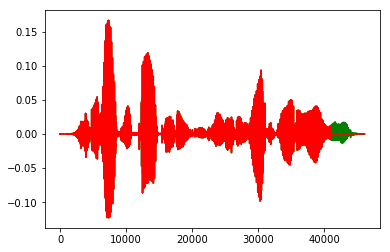

In [20]:
tfm_tester(example, tfm_pad_with_silence)

## Pitch Warp

In [21]:
#Export
def tfm_pitch_warp(ad:AudioData, shift_by_pitch=None, bins_per_octave=12, **kwargs)->AudioData:
    min_len = 600 # librosa requires a signal of length at least 500
    copy = ad.sig.clone()
    if (copy.shape[0] < min_len): copy = torch.cat((copy, torch.zeros(min_len - copy.shape[0])))
    if shift_by_pitch is None: shift_by_pitch = random.uniform(-3, 3)
    sig = torch.tensor(librosa.effects.pitch_shift(np.array(copy), ad.sr, shift_by_pitch, bins_per_octave))
    return AudioData(sig,ad.sr)

## Lossy Downsample and Upsample

In [22]:
#Export
def tfm_down_and_up(ad:AudioData, sr_divisor=2, **kwargs)->AudioData:
    copy = np.array(ad.sig.clone())
    down = librosa.audio.resample(copy, ad.sr, ad.sr/sr_divisor)
    sig = torch.tensor(librosa.audio.resample(down, ad.sr/sr_divisor, ad.sr))
    return AudioData(sig,ad.sr)

sr:16000   sig.shape:torch.Size([46080])


sr:16000   sig.shape:torch.Size([46080])


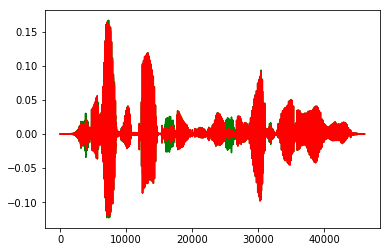

In [23]:
tfm_tester(example, tfm_down_and_up)

## Signal Mixup

In [24]:
#Export
def tfm_signal_mixup(signal, **kwargs):
    pass

## Combined Augmentations

sr:16000   sig.shape:torch.Size([46080])


sr:16000   sig.shape:torch.Size([46080])


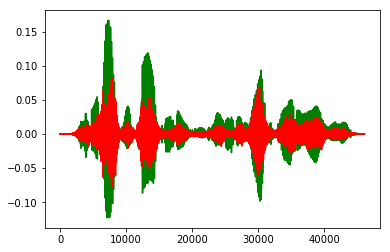

In [25]:
tfm_tester(example, [tfm_down_and_up, tfm_pitch_warp, tfm_pad_with_silence])

sr:16000   sig.shape:torch.Size([46080])


sr:16000   sig.shape:torch.Size([46080])


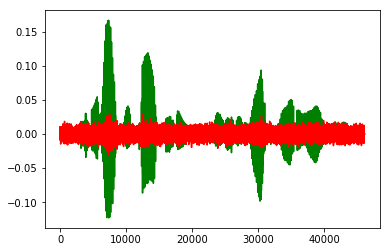

In [26]:
tfm_tester(example, [tfm_modulate_volume, tfm_pitch_warp, tfm_add_white_noise, tfm_pad_with_silence])

In [27]:
# Other stuff to possibly explore
# AudioSegment(…).overlay()
# AudioSegment(…).apply_gain(gain)
# AudioSegment(…).invert_phase()
# AudioSegment(…).set_sample_width()

# Generic Transforms

### Pad to maximum value (resize)

In [28]:
#Export
def tfm_pad_to_max(ad:AudioData, mx=1000):
    """Pad tensor with zeros (silence) until it reaches length `mx`"""
    copy = ad.sig.clone()
    if (copy.shape[0] < mx): copy = torch.cat((copy, torch.zeros(mx - copy.shape[0])))
    if (copy.shape[0] > mx): copy = copy[:mx]
    return AudioData(copy, ad.sr)

sr:16000   sig.shape:torch.Size([46080])


sr:16000   sig.shape:torch.Size([46080])


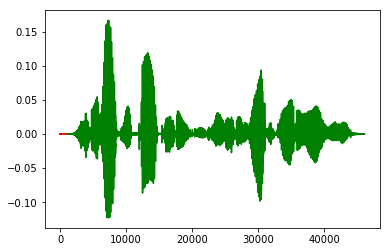

In [29]:
tfm_tester(example, partial(tfm_pad_to_max))

sr:16000   sig.shape:torch.Size([46080])


sr:16000   sig.shape:torch.Size([46080])


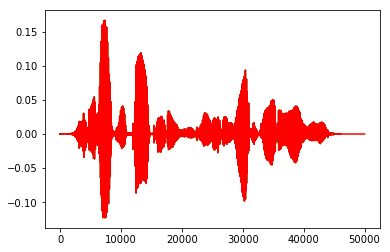

In [30]:
tfm_tester(example, partial(tfm_pad_to_max, mx=50000))

### Log input type and properties

In [31]:
#Export
def tfm_log(x, show=False, logOnlyFirst=True, msg=''):
    '''Fake transformation that logs x shape'''
    #TODO: implements the optional "show" and "logOnlyFirst"
    if isinstance(x,AudioData): print(f'{msg}{type(x).__name__} >> Shape of signal: {x.sig.shape}  sr: {x.sr}')
    elif hasattr(x,'shape'): print(f'{msg}{type(x).__name__} >> Shape: {x.shape}')
    else: print(f'{msg}{type(x).__name__}')
    return x

AudioData >> Shape of signal: torch.Size([46080])  sr: 16000
sr:16000   sig.shape:torch.Size([46080])


sr:16000   sig.shape:torch.Size([46080])


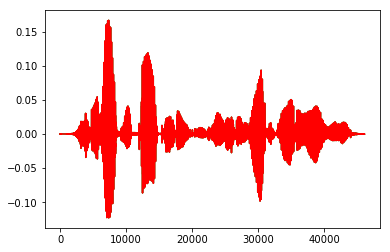

In [32]:
tfm_tester(example, tfm_log)

## Formatting Transforms

In [33]:
#Export
def tfm_extract_signal(ad:AudioData):
    return ad.sig

In [34]:
#Export
def tfm_spectro(ad:AudioData, n_mels=128):
    # We must reshape signal for torchaudio to generate the spectrogram.
#     hop = ad.sig.shape[0] // n_mels
    return transforms.MelSpectrogram(sr=ad.sr, n_mels=n_mels)(ad.sig.reshape(1, -1))

# Export

In [35]:
!python notebook2script.py DataAugmentation.ipynb

  File "notebook2script.py", line 15
    fname_out = f'nb_{fname.stem.split("_")[0]}.py'
                                                  ^
SyntaxError: invalid syntax
